<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os 

In [45]:
sns.set_style("darkgrid")
sns.color_palette("husl", 9)
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Manipulate Happiness Data</h2>

In [3]:
html = pd.read_html("happiest_cities.html")

In [4]:
happiness_df = html[0]

In [5]:
happiness_df = happiness_df.rename(columns = {'City': 'Location'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [6]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [7]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [8]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

In [9]:
for col in list(locations_df.columns):
    subset = locations_df[col]
    counts = pd.isnull(subset)
    counts = counts.value_counts()
    if True in counts.values:
        print(f"{col} contains missing values")

<h4>Setting Ranking Columns as Category</h4>

In [10]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [11]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [12]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [13]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [14]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [15]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>

<p><b>St. Paul Minnestoa</b></p>

In [16]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [17]:
exploded[exploded['state'] == 'MN'][['city', 'state']].sample(10)

,city,state
127535,WINONA,MN
125532,BLOOMINGTON,MN
128606,ST. PAUL,MN
127416,BRAINERD,MN
127575,MINNEAPOLIS,MN
125793,MINNEAPOLIS,MN
125488,MINNEAPOLIS,MN
128131,BRAINERD,MN
128401,ROCHESTER,MN
128646,ST. PAUL,MN


<p><b>New York City, NY</b></p>

In [18]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [19]:
exploded[exploded['state'] == 'NY'][['city', 'state']].sample(10)

,city,state
143034,NEW YORK,NY
162997,NEWARK,NY
154856,SCHENECTADY,NY
149263,NEW YORK,NY
155929,ROME,NY
161660,NEW YORK,NY
162613,NEWARK,NY
143242,JERSEY CITY,NY
149828,JERSEY CITY,NY
161665,NEW YORK,NY


<p><b>Washington, D.C.</b></p>

In [20]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [21]:
happiness_df[happiness_df['city'] == 'Arlington'][['city', 'state']]

,city,state


In [22]:
happiness_df[happiness_df['city'] == 'Alexandria'][['city', 'state']]

,city,state


In [23]:
exploded[exploded['state'] == 'DC'][['city', 'state']].sample(10)

,city,state
20633,ARLINGTON,DC
110059,ALEXANDRIA,DC
61523,WASHINGTON,DC
17031,ARLINGTON,DC
19033,ARLINGTON,DC
61557,ALEXANDRIA,DC
110925,ALEXANDRIA,DC
16694,ARLINGTON,DC
18660,WASHINGTON,DC
111298,ARLINGTON,DC


<h4>Joining</h4>

In [24]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [25]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [26]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [27]:
regions = {}

regions['Pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['Mountain West'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['West North Central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['West South Central'] = ['TX', 'OK', 'AR', 'LA']

regions['East North Central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['East South Central'] = ['KY', 'TN', 'MS', 'AL']

regions['South Atlantiic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['Middle Atlantic'] = ['PA', 'NY', 'NJ']

regions['New England'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['US Territories'] = ['PR']

In [28]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [29]:
df['Region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 8.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
# axes[0].annotate('figure pixels', xy=(160, 55), xycoords='figure pixels')

fig.suptitle("Effect of Aggregating by City on Analysis", fontsize = 14)

<h3>Actual Visualization</h3>

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

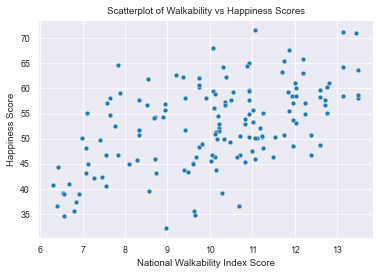

In [31]:
g = sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

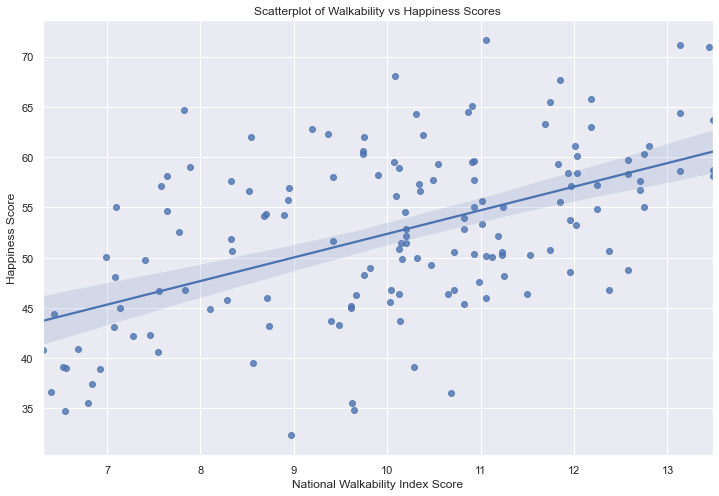

In [46]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.4, 1.05, 'Scatterplot of Walkability vs Happiness Scores')

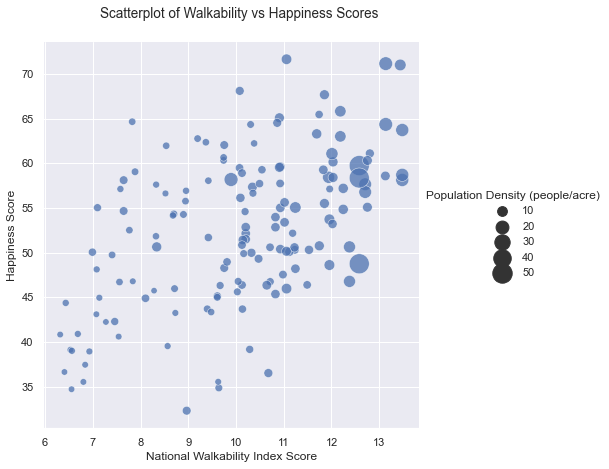

In [47]:
df = df.rename(columns = {'D1B' : 'Population Density (people/acre)'})

g = sns.relplot(x = "NatWalkInd", y = "Total Score", size = "Population Density (people/acre)",
            sizes = (40, 400), alpha = 0.75, palette = "muted", 
            height = 6, data = df)

# plt.legend(loc = 'lower right', borderaxespad = 2, title = 'Population Density (people/acre)')

g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.fig.suptitle("Scatterplot of Walkability vs Happiness Scores", y = 1.05, x = 0.4, fontsize = 13.5)


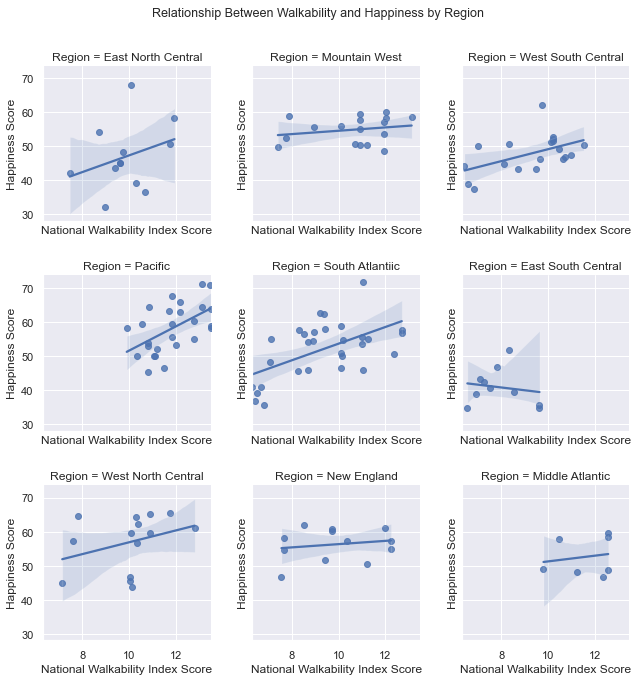

In [48]:
g = sns.FacetGrid(df, col = "Region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "Total Score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05, fontsize = 12.5)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

In [53]:
by_region = df.groupby('Region')
happiness_by_region = by_region.describe()['Total Score'].sort_values(by = 'mean', ascending = False)

In [54]:
happiness_by_region

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Pacific,26.0,58.197692,7.129642,45.36,52.9325,58.440,63.6125,71.15
West North Central,14.0,56.905000,8.147176,43.68,49.2475,59.510,63.8100,65.46
New England,12.0,56.260000,4.726731,46.71,53.9175,57.265,60.4025,61.96
Mountain West,17.0,54.908824,3.884067,48.61,50.6000,55.760,58.4100,60.15
Middle Atlantic,7.0,52.642857,5.650194,46.78,48.4750,48.960,58.0350,59.74
South Atlantiic,30.0,51.932667,8.224281,35.53,46.0725,54.215,56.8850,71.64
West South Central,19.0,47.870000,5.507775,37.45,44.6300,47.540,51.0250,62.04
East North Central,12.0,47.002500,9.874877,32.31,41.5100,45.075,51.6500,68.10
East South Central,10.0,40.815000,5.477518,34.71,36.3900,40.070,42.8850,51.83


In [55]:
walkability_by_region = by_region.describe()['NatWalkInd'].sort_values(by = 'mean', ascending = False)
walkability_by_region

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Pacific,26.0,11.856247,1.086017,9.896071,10.911850,11.841573,12.753929,13.484239
Middle Atlantic,7.0,11.668197,1.156204,9.811961,10.868996,12.378503,12.582974,12.582974
Mountain West,17.0,10.636201,1.686640,7.403101,10.092593,10.928131,11.957625,13.130435
West North Central,14.0,10.016230,1.562800,7.135615,10.032515,10.220284,10.777336,12.805164
New England,12.0,9.863358,1.788896,7.557870,8.314153,9.740230,11.421809,12.246888
East North Central,12.0,9.851519,1.245129,7.458409,9.289736,9.680701,10.384600,11.940212
South Atlantiic,30.0,9.306112,1.890165,6.314947,8.293335,9.281732,10.810588,12.707212
West South Central,19.0,9.262742,1.604228,6.430667,8.220822,9.753016,10.338132,11.530039
East South Central,10.0,7.936037,1.084716,6.553166,7.123344,7.688772,8.505666,9.640000


Text(0.5, 0.98, 'Walkability Index vs Happiness Score Components')

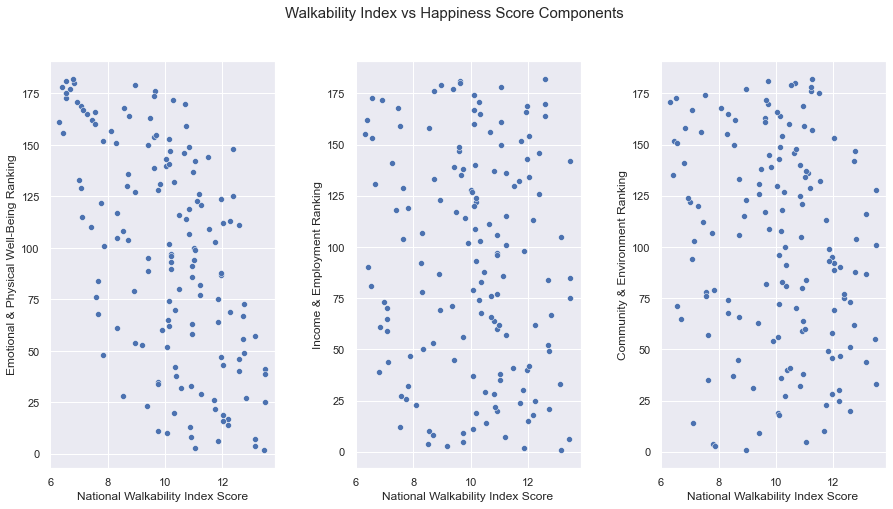

In [56]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

axes[0] = sns.scatterplot(x = 'NatWalkInd', y = 'Emotional & Physical Well-Being', data = df, ax = axes[0])
axes[1] = sns.scatterplot(x = 'NatWalkInd', y = 'Income & Employment', data = df, ax = axes[1])
axes[2] = sns.scatterplot(x = 'NatWalkInd', y = 'Community & Environment', data = df, ax = axes[2])


axes[0].set(xlabel = 'National Walkability Index Score', ylabel = 'Emotional & Physical Well-Being Ranking')
axes[1].set(xlabel = 'National Walkability Index Score', ylabel = 'Income & Employment Ranking')
axes[2].set(xlabel = 'National Walkability Index Score', ylabel = 'Community & Environment Ranking')

fig.suptitle("Walkability Index vs Happiness Score Components", fontsize = 15)

<p>People Enjoy Living in Walkable Community, but not when it comes with the trade off of not owning a vehicle</p>
<p>Owning a car isn't a simple choice of walkability vs not, household wealth is a big confounding variable here</p>

<h3>Average Happiness Score by Walkability Score Level</h3>

Text(0.5, 0.98, 'Happiness Scores vs Walkability Index Ranking')

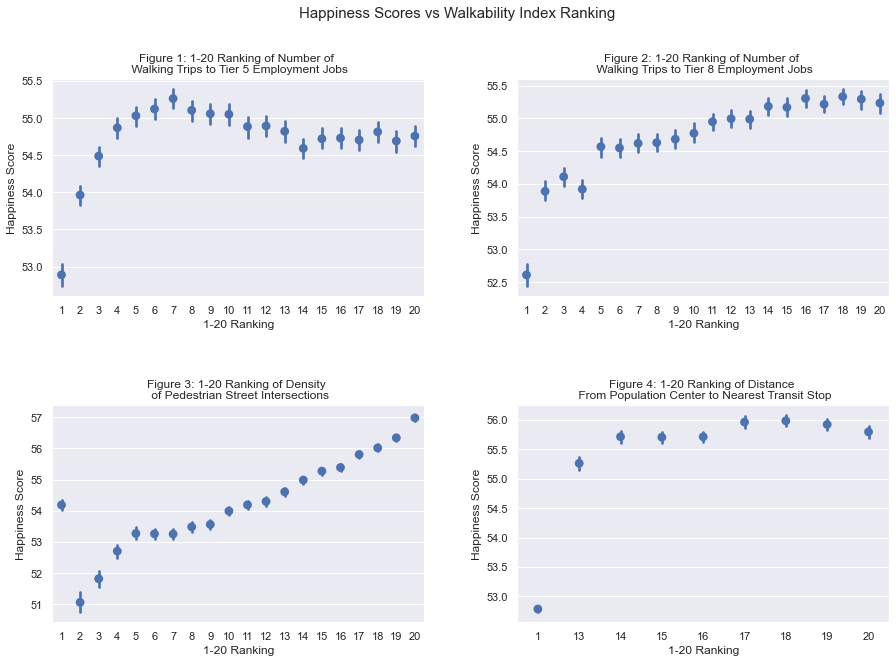

In [57]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for i, ax in enumerate(axes.flatten()):
    g = sns.pointplot(x = targets[i], y = 'Total Score', data = matches, join = False, ax = ax)
    g.set_xticklabels(g.get_xticklabels())
    g.set_xlabel(xlabel = '1-20 Ranking')
    g.set_ylabel('Happiness Score')
    
# set titles
axes[0][0].set_title('Figure 1: 1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[0][1].set_title('Figure 2: 1-20 Ranking of Number of \n Walking Trips to Tier 8 Employment Jobs')
axes[1][0].set_title('Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')
axes[1][1].set_title('Figure 4: 1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

fig.suptitle("Happiness Scores vs Walkability Index Ranking", fontsize = 15)